In [157]:
import random
import math

class MaxHeapq:
    """
    A custom Max-Heap implementation built from scratch.
    
    The 'heappop' method returns the "greatest" item. We will define "greatest"
    in the Task class to mean "highest priority".
    """
    def __init__(self):
        """Initializes the heap as an empty list."""
        self.heap = []
    
    # --- Per-Assignment Helper Methods ---

    def left(self, i):
        """Gets the index of the left child node."""
        return 2 * i + 1

    def right(self, i):
        """Gets the index of the right child node."""
        return 2 * i + 2

    def parent(self, i):
        """Gets the index of the parent node."""
        return (i - 1) // 2

    # --- Internal Helper Methods (Kept for functionality) ---

    def __bool__(self):
        """Returns True if the heap is not empty, False otherwise."""
        return bool(self.heap)

    def _has_parent(self, i):
        """Checks if a node has a parent."""
        # Uses the new public 'parent' method
        return self.parent(i) >= 0

    def _has_left_child(self, i):
        """Checks if a node has a left child."""
        # Uses the new public 'left' method
        return self.left(i) < len(self.heap)

    def _has_right_child(self, i):
        """Checks if a node has a right child."""
        # Uses the new public 'right' method
        return self.right(i) < len(self.heap)

    def _swap(self, index1, index2):
        """Swaps two elements in the heap."""
        self.heap[index1], self.heap[index2] = self.heap[index2], self.heap[index1]

    # Internal "sift up" helper, required by heappush.
    # We update it to use the new public 'parent' method.
    def _heapify_up(self, i):
        """Moves an item up the heap as long as it is 'greater' than its parent."""
        # While the item has a parent and is GREATER than its parent
        while self._has_parent(i) and self.heap[i] > self.heap[self.parent(i)]:
            parent_idx = self.parent(i)
            self._swap(i, parent_idx)
            i = parent_idx # Move up to the parent's index
            
    # --- Per-Assignment Core Methods ---

    def heappush(self, key):
        """
        Adds a new item (key) to the heap and sifts it up to its
        correct position to maintain the max-heap property.
        """
        self.heap.append(key)
        self._heapify_up(len(self.heap) - 1)

    def heapify(self, i):
        """
        Moves an item down the heap from index 'i' to its correct position
        to maintain the max-heap property (sift-down).
        """
        # Continue as long as the node has at least one child
        while self._has_left_child(i):
            # Assume the left child is the larger one
            larger_child_index = self.left(i)
            
            # Check if a right child exists and is *larger* than the left child
            if (self._has_right_child(i) and 
                self.heap[self.right(i)] > self.heap[larger_child_index]):
                larger_child_index = self.right(i)

            # If the current node is *smaller* than its largest child, swap them
            if self.heap[i] < self.heap[larger_child_index]:
                self._swap(i, larger_child_index)
                i = larger_child_index # Move down to the child's index
            else:
                # The node is in its correct place (it's >= its children)
                break

    def heappop(self):
        """
        Removes and returns the highest-priority item (the max) from the heap.
        Sifts the new root down to maintain the max-heap property.
        """
        if not self.heap:
            raise IndexError("pop from an empty heap")
        
        if len(self.heap) == 1:
            return self.heap.pop()

        # Get the root item (which is the "max" or highest-priority)
        root = self.heap[0]
        
        # Move the last item to the root
        self.heap[0] = self.heap.pop()
        
        # Sift the new root down to its correct position
        self.heapify(0) # Use the new public 'heapify' (sift-down) method
        
        return root

In [158]:
# Reference code from Session 13 - Heaps and priority queues

class Task:
    """
    Represents a single task with its dependencies, duration, and time constraints.

    Attributes:
        id (int): The unique identifier for the task.
        description (str): A brief description of the task.
        duration (int): The time in minutes required to complete the task.
        dependencies (list): A list of task IDs that must be completed before this task can start.
        earliest_start_time (int): The earliest time (in minutes from start) this task can begin.
        latest_start_time (int): The latest time (in minutes from start) this task must begin.
        status (str): The current status of the task (N, I, C).
        priority (float): A random float used for tie-breaking in the priority queue.
    """
    
    def __init__(self, id, description, duration,
                 dependencies, earliest_start_time=None, latest_start_time=None, status="N"):
        """
        Initializes a new Task instance.
        
        Args:
            id (int): Task ID.
            description (str): Task description.
            duration (int): Task duration in minutes.
            dependencies (list): List of prerequisite task IDs.
            earliest_start_time (int, optional): Earliest start time in minutes.
            latest_start_time (int, optional): Latest start time (deadline) in minutes.
            status (str, optional): Initial status, defaults to 'N' (Not Started).
        """
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.earliest_start_time = earliest_start_time
        self.latest_start_time = latest_start_time
        self.status = status
        
        # Assign a random priority for tie-breaking between otherwise equal tasks
        self.priority = random.random()
    
    def _get_priority_tuple(self):
        """Helper function to create the tuple used for comparisons."""
        # Use math.inf as a "fallback" if no time is specified
        e_start = math.inf if self.earliest_start_time is None else self.earliest_start_time
        l_start = math.inf if self.latest_start_time is None else self.latest_start_time
        
        return (e_start, l_start, self.priority)

    def __gt__(self, other):
            """
            Defines 'greater than' for the Max-Heap.
            
            A task is 'greater' if it has HIGHER priority.
            Higher priority means a "smaller" priority tuple (e.g., earlier start time).
            
            Returns:
                bool: True if this task has higher priority than 'other', False otherwise.
            """
            self_tuple = self._get_priority_tuple()
            other_tuple = other._get_priority_tuple()
            
            # 'self' is "greater" (higher priority) if its tuple is "less than"
            return self_tuple < other_tuple
    
    def __lt__(self, other):
        """
        Defines 'less than' for the Max-Heap.
        
        A task is 'less' if it has LOWER priority.
        Lower priority means a "larger" priority tuple (e.g., later start time).
        """
        self_tuple = self._get_priority_tuple()
        other_tuple = other._get_priority_tuple()
        
        # 'self' is "less than" (lower priority) if its tuple is "greater than"
        return self_tuple > other_tuple
    
    def __eq__(self, other):
        """Defines equality based on the priority tuple."""
        if not isinstance(other, Task):
            return False
        return self._get_priority_tuple() == other._get_priority_tuple()
    
class TaskScheduler:
    """
    Manages a list of Task objects and runs a simulation to create a viable schedule.
    
    Uses a priority queue to manage "ready" tasks and a separate list for
    tasks that are "time-blocked" (i.e., waiting for their start time).
    """
    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'
    SKIPPED = 'S'
    
    def __init__(self, tasks):
        """
        Initializes the TaskScheduler.
        
        Args:
            tasks (list): A list of Task objects to be scheduled.
        """
        self.tasks = tasks
        self.task_map = {task.id: task for task in tasks}
        
        self.priority_queue = MaxHeapq() 
        
        self.time_blocked_tasks = []
        
    def print_self(self):
        """Prints summary of all tasks and their constraints."""
        print("Tasks added to the scheduler:")
        print("---------------------------------------")
        for t in self.tasks:
            print(f"➡️'{t.description}', duration = {t.duration} mins.")   
            
            if t.dependencies:
                try:
                    # Look up dependency descriptions for a friendlier print
                    dep_descriptions = [self.task_map[dep_id].description for dep_id in t.dependencies]
                    # Cleaner f-string for embedding quotes
                    print(f"\t ⚠️ Depends on: \"{', '.join(dep_descriptions)}\"")
                except KeyError as e:
                    print(f"\t ⚠️ Error: Dependency ID {e} not found!")
            
            # Print the correct time constraint type
            if t.earliest_start_time and t.latest_start_time:
                if t.earliest_start_time == t.latest_start_time:
                    print(f"\t ⏰ FIXED: Must start exactly at {self.format_time(t.earliest_start_time)}")
                else:
                    print(f"\t ⏰ WINDOW: Must run between {self.format_time(t.earliest_start_time)} and {self.format_time(t.latest_start_time)}")
            elif t.earliest_start_time:
                print(f"\t ⏰ EARLIEST: Cannot start before {self.format_time(t.earliest_start_time)}")
            elif t.latest_start_time:
                print(f"\t ⏰ DEADLINE: Must start by {self.format_time(t.latest_start_time)}")
            else:
                print(f"\t ⏰ FLEXIBLE: No time constraints")
            
    def remove_dependency(self, id):
        """
        Removes a completed task ID from the dependency lists of all other tasks.
        
        Args:
            id (int): The ID of the task that has just been completed.
        """
        for t in self.tasks:
            if t.id != id:
                try:
                    t.dependencies.remove(id)
                except ValueError:
                    # This task didn't have the dependency, which is fine
                    pass           
            
    def get_tasks_ready(self):
        """Finds tasks with no remaining dependencies and adds them to the priority queue."""
        for task in self.tasks:
            if task.status == self.NOT_STARTED and not task.dependencies: 
                task.status = self.IN_PRIORITY_QUEUE
                
                self.priority_queue.heappush(task)
    
    def move_ready_time_blocked_tasks(self, current_time):
        """
        Moves tasks from the time-blocked list back to the main priority queue
        if their 'earliest_start_time' has been reached.
        
        Args:
            current_time (int): The current simulation time.
        """
        still_blocked = []
        for task in self.time_blocked_tasks:
            if task and (task.earliest_start_time is None or current_time >= task.earliest_start_time):
                self.priority_queue.heappush(task)
            else:
                # Task is still time-blocked, keep it in this list
                still_blocked.append(task)
        
        self.time_blocked_tasks = still_blocked

    def check_unscheduled_tasks(self):
        """
        Checks if any tasks are not yet marked as COMPLETED or SKIPPED.
        
        Returns:
            bool: True if unfinished tasks remain, False otherwise.
        """
        return any(t.status not in (self.COMPLETED, self.SKIPPED) for t in self.tasks)
    
    def update_task_status(self, task_id, new_status):
        """
        Manually updates a task's status and handles dependency removal.
        
        This is used to "catch up" the scheduler with reality,
        e.g., marking tasks as COMPLETED or SKIPPED before re-running.

        Args:
            task_id (int): The ID of the task to update.
            new_status (str): The new status (e.g., 'C' or 'S').
        """
        try:
            task = self.task_map[task_id]
        except KeyError:
            print(f"Error: Task ID {task_id} not found.")
            return

        # Only remove dependencies if the task is being "finished"
        if new_status == self.COMPLETED or new_status == self.SKIPPED:
            # Check if it's not already finished
            if task.status != self.COMPLETED and task.status != self.SKIPPED:
                print(f"INFO: Manually setting task '{task.description}' to {new_status}.")
                task.status = new_status
                # Unblock all tasks that depended on this one.
                self.remove_dependency(task_id)
            else:
                print(f"INFO: Task '{task.description}' was already {task.status}.")
        else:
            # For other statuses like 'N' or 'I', just update it
            task.status = new_status

    def format_time(self, time):
        """
        Converts minutes-from-start into a human-readable string.
        
        Args:
            time (int): Time in minutes.
            
        Returns:
            str: Formatted time string (e.g., "9h30" or "Day 2, 2h30").
        """
        if not isinstance(time, (int, float)):
            return "Invalid time"
        
        time = int(time) # Ensure we're working with integers
        days = time // 1440 # 1440 minutes in a day
        minutes_today = time % 1440
        hour = minutes_today // 60
        minute = minutes_today % 60
        
        if days > 0:
            return f"Day {days+1}, {hour}h{minute:02d}"
        return f"{hour}h{minute:02d}"
    
    def run_task_scheduler(self, starting_time):
        """
        Runs the main scheduling simulation loop.
        
        Continues until all tasks are completed or a deadlock is detected.
        
        Args:
            starting_time (int): The time (in minutes) to start the simulation.
        """
        current_time = starting_time
        print("Running the scheduler:\n")
        
        while self.check_unscheduled_tasks():
            
            self.get_tasks_ready()
            
            self.move_ready_time_blocked_tasks(current_time)
            
            # This check uses MaxHeapq.__bool__(), which is unchanged
            if self.priority_queue:
                
                task = self.priority_queue.heappop()
                
                # ... (Check 1: earliest_start_time) ...
                if task.earliest_start_time is not None and current_time < task.earliest_start_time:
                    self.time_blocked_tasks.append(task)
                    continue
                
                # ... (Check 1.5: latest_start_time) ...
                if task.latest_start_time is not None and current_time > task.latest_start_time:
                    print(f"🕰t={self.format_time(current_time)} - ⚠️ MISSED: Task '{task.description}' was skipped. (Deadline was {self.format_time(task.latest_start_time)})")
                    task.status = self.SKIPPED
                    self.remove_dependency(task.id)
                    continue 

                # ... (Check 2: Look ahead) ...
                next_hard_start_time = math.inf
                if self.time_blocked_tasks:
                    valid_times = [t.earliest_start_time for t in self.time_blocked_tasks if t.earliest_start_time is not None]
                    if valid_times:
                        next_hard_start_time = min(valid_times)
                
                task_end_time = current_time + task.duration
                
                if task_end_time > next_hard_start_time:
                    print(f"🕰t={self.format_time(current_time)}... Delaying flexible task '{task.description}' to keep {self.format_time(next_hard_start_time)} free.")
                    
                    # *** CHANGED HERE: Use the new .heappush() method ***
                    self.priority_queue.heappush(task)
                    
                    current_time = next_hard_start_time
                    continue
                
                # ... (Execute the task - unchanged) ...
                print(f"🕰t={self.format_time(current_time)}")
                print(f"\tstarted '{task.description}' for {task.duration} mins...")
                current_time += task.duration            
                print(f"\t✅ t={self.format_time(current_time)}, task completed!") 
                
                self.remove_dependency(task.id)
                task.status = self.COMPLETED
            
            elif self.time_blocked_tasks:
                # ... (Waiting logic - unchanged) ...
                try:
                    next_available_time = min(t.earliest_start_time for t in self.time_blocked_tasks if t.earliest_start_time is not None)
                except ValueError:
                     print(f"🕰t={self.format_time(current_time)} - ERROR: Time-blocked, but no valid start time!")
                     break
                
                if current_time < next_available_time:
                    print(f"🕰t={self.format_time(current_time)}... no tasks runnable. Waiting until {self.format_time(next_available_time)}...")
                    current_time = next_available_time
            
            elif self.check_unscheduled_tasks():
                 # ... (Deadlock logic - unchanged) ...
                 print(f"🕰t={self.format_time(current_time)} - ERROR: Deadlock detected!")
                 # Let's see which tasks are causing the deadlock
                 print("     Unfinished tasks with dependencies:")
                 for t in self.tasks:
                     if t.status == self.NOT_STARTED and t.dependencies:
                         try:
                             dep_descs = [self.task_map[dep_id].description for dep_id in t.dependencies]
                             print(f"     - '{t.description}' is waiting on: {', '.join(dep_descs)}")
                         except KeyError:
                             print(f"     - '{t.description}' is waiting on an unknown task ID.")
                 break
            
        total_time = current_time - starting_time             
        print(f"\n🏁 Completed all planned tasks in {int(total_time)//60}h{int(total_time)%60:02d}min!")

    def reschedule_from(self, current_time, completed_ids, skipped_ids):
        """
        Updates the schedule based on real-world progress and reruns
        the scheduler from the specified time.

        This method encapsulates the process of "catching up" the
        scheduler with reality before finding a new plan.

        Args:
            current_time (int): The new time (in minutes) to start from.
            completed_ids (list): A list of task IDs that are already completed.
            skipped_ids (list): A list of task IDs that were missed or skipped.
        """
        print("==================================================")
        print(f"🗓️  ADAPTIVE SCHEDULE: RERUNNING FROM {self.format_time(current_time)}")
        print("==================================================")
        
        print("--- Updating Scheduler with Real-World Status ---")
        
        # Mark all completed tasks
        for task_id in completed_ids:
            self.update_task_status(task_id, self.COMPLETED)
            
        # Mark all skipped tasks
        for task_id in skipped_ids:
            self.update_task_status(task_id, self.SKIPPED)

        print("-------------------------------------------------")

        # Now, run the scheduler with the remaining tasks from the new time
        print(f"\n--- Re-Running Scheduler ---")
        self.run_task_scheduler(current_time)

In [159]:
# Reference code from Session 13 - Heaps and priority queues

"""
List of Tasks - 5 Nov 2025:

• Fixed tasks:
1) Take CS111 class

• Partly Timed Tasks
1) Wake up at 09:30
2) Have lunch at 14:30
3) Buy Bento at Lincos after gym after 20:00
4) Go to bed before 02:30

• Non-timely tasks:
1) Make CS113 Pre-Class Work
2) Have Japan's signature drink - Matcha Green Tea
3) Go to the gym
4) Buy 100¥ (~$0.65) Snacks for Kamaishi Trip at Mini Stop after Lincos
5) Take shower after gym
6) Have dinner

"""

def get_pristine_tasks():
    """
    Returns a new, unaltered list of all Task objects for a simulation.
    
    Calling this ensures that each simulation run starts with
    fresh data (like original dependencies) and new random priorities 
    for tie-breaking.
    """
    tasks = [
        Task(id=0, description='Wake up at 09:30', 
             duration=10, dependencies=[], earliest_start_time=570), 
        Task(id=1, description='Have lunch at 14:30', 
             duration=60, dependencies=[0], earliest_start_time=870), 
        Task(id=2, description='Go to the gym', 
             duration=120, dependencies=[0, 1]), 
        Task(id=3, description='Buy Bento at Lincos after gym after 20:00', 
             duration=25, dependencies=[0, 2], earliest_start_time=1200), 
        Task(id=4, description='Buy 100¥ (~$0.65) Snacks for Kamaishi Trip at Mini Stop after Lincos', 
             duration=10, dependencies=[0, 1, 3]), 
        Task(id=5, description='Take shower after gym', 
             duration=30, dependencies=[0, 2]), 
        Task(id=6, description='Have dinner', 
             duration=40, dependencies=[0, 5]), 
        Task(id=7, description='Prepare luggage for Kamaishi Trip', 
             duration=100, dependencies=[0, 6]),
         Task(id=8, description='Make CS113 Pre-Class Work', 
             duration=120, dependencies=[0, 7]),
         Task(id=9, description="Have Japan's signature drink - Matcha Green Tea", 
             duration=15, dependencies=[0]),
         Task(id=10, description='Go to bed before 02:30', 
             duration=15, dependencies=[0, 1, 4, 6, 7, 8, 9], earliest_start_time=22*60, latest_start_time=26*60+30),
         Task(id=11, description="Attend CS111 Session from 16:00 to 17:30",
              duration=90, dependencies=[0], earliest_start_time=16*60, latest_start_time=16*60)
        ]
    return tasks

# This part just prints the task definitions once for review
task_scheduler_printer = TaskScheduler(get_pristine_tasks())
print("--- Printing Task Definitions ---")
task_scheduler_printer.print_self()
print("---------------------------------")

--- Printing Task Definitions ---
Tasks added to the scheduler:
---------------------------------------
➡️'Wake up at 09:30', duration = 10 mins.
	 ⏰ EARLIEST: Cannot start before 9h30
➡️'Have lunch at 14:30', duration = 60 mins.
	 ⚠️ Depends on: "Wake up at 09:30"
	 ⏰ EARLIEST: Cannot start before 14h30
➡️'Go to the gym', duration = 120 mins.
	 ⚠️ Depends on: "Wake up at 09:30, Have lunch at 14:30"
	 ⏰ FLEXIBLE: No time constraints
➡️'Buy Bento at Lincos after gym after 20:00', duration = 25 mins.
	 ⚠️ Depends on: "Wake up at 09:30, Go to the gym"
	 ⏰ EARLIEST: Cannot start before 20h00
➡️'Buy 100¥ (~$0.65) Snacks for Kamaishi Trip at Mini Stop after Lincos', duration = 10 mins.
	 ⚠️ Depends on: "Wake up at 09:30, Have lunch at 14:30, Buy Bento at Lincos after gym after 20:00"
	 ⏰ FLEXIBLE: No time constraints
➡️'Take shower after gym', duration = 30 mins.
	 ⚠️ Depends on: "Wake up at 09:30, Go to the gym"
	 ⏰ FLEXIBLE: No time constraints
➡️'Have dinner', duration = 40 mins.
	 ⚠️ Dep

In [160]:
# Reference code from Session 13 - Heaps and priority queues

# Running the Scheduler
start_scheduler_at = int((9.5)*60) # 9:30 AM

# Loop 2 times to create 2 different schedule alternatives
for i in range(2):
    print(f"\n{'='*30}")
    print(f"🗓️ SCHEDULE ALTERNATIVE {i+1}")
    print(f"{'='*30}")
    
    # Get a fresh, new list of tasks with new random priorities
    fresh_tasks = get_pristine_tasks()
    
    # Create and run a new scheduler instance for this alternative
    task_scheduler = TaskScheduler(fresh_tasks)
    task_scheduler.run_task_scheduler(start_scheduler_at)


🗓️ SCHEDULE ALTERNATIVE 1
Running the scheduler:

🕰t=9h30
	started 'Wake up at 09:30' for 10 mins...
	✅ t=9h40, task completed!
🕰t=9h40
	started 'Have Japan's signature drink - Matcha Green Tea' for 15 mins...
	✅ t=9h55, task completed!
🕰t=9h55... no tasks runnable. Waiting until 14h30...
🕰t=14h30
	started 'Have lunch at 14:30' for 60 mins...
	✅ t=15h30, task completed!
🕰t=15h30... Delaying flexible task 'Go to the gym' to keep 16h00 free.
🕰t=16h00
	started 'Attend CS111 Session from 16:00 to 17:30' for 90 mins...
	✅ t=17h30, task completed!
🕰t=17h30
	started 'Go to the gym' for 120 mins...
	✅ t=19h30, task completed!
🕰t=19h30
	started 'Take shower after gym' for 30 mins...
	✅ t=20h00, task completed!
🕰t=20h00
	started 'Buy Bento at Lincos after gym after 20:00' for 25 mins...
	✅ t=20h25, task completed!
🕰t=20h25
	started 'Have dinner' for 40 mins...
	✅ t=21h05, task completed!
🕰t=21h05
	started 'Prepare luggage for Kamaishi Trip' for 100 mins...
	✅ t=22h45, task completed!
🕰t=22h45
	

In [161]:
# Running the Adaptive Scheduler

# 1. Get a "pristine" list of all tasks.
# We must do this to get a fresh copy with original dependencies.
adaptive_tasks = get_pristine_tasks()

# 2. Create a new scheduler instance.
rescheduler = TaskScheduler(adaptive_tasks)

# 3. Define the current time:
# It's 8:30 PM (1230 minutes)
new_start_time = 1230 

# Tasks already done:
tasks_done = [0, 1, 11] # Wake up, Lunch, CS111

# Tasks missed:
tasks_missed = [2, 5] # Go to the gym, Take shower after gym

# 4. Call your new method to find a new plan.
rescheduler.reschedule_from(
    current_time=new_start_time,
    completed_ids=tasks_done,
    skipped_ids=tasks_missed
)

🗓️  ADAPTIVE SCHEDULE: RERUNNING FROM 20h30
--- Updating Scheduler with Real-World Status ---
INFO: Manually setting task 'Wake up at 09:30' to C.
INFO: Manually setting task 'Have lunch at 14:30' to C.
INFO: Manually setting task 'Attend CS111 Session from 16:00 to 17:30' to C.
INFO: Manually setting task 'Go to the gym' to S.
INFO: Manually setting task 'Take shower after gym' to S.
-------------------------------------------------

--- Re-Running Scheduler ---
Running the scheduler:

🕰t=20h30
	started 'Buy Bento at Lincos after gym after 20:00' for 25 mins...
	✅ t=20h55, task completed!
🕰t=20h55
	started 'Have Japan's signature drink - Matcha Green Tea' for 15 mins...
	✅ t=21h10, task completed!
🕰t=21h10
	started 'Have dinner' for 40 mins...
	✅ t=21h50, task completed!
🕰t=21h50
	started 'Buy 100¥ (~$0.65) Snacks for Kamaishi Trip at Mini Stop after Lincos' for 10 mins...
	✅ t=22h00, task completed!
🕰t=22h00
	started 'Prepare luggage for Kamaishi Trip' for 100 mins...
	✅ t=23h40, tas

Starting scheduler performance benchmark...
N values: [10, 50, 100, 150, 200, 300, 400, 500, 600, 700]
Trials per N: 10

Processing N = 10   (running 10 trials)... done in 0.01 seconds.
Processing N = 50   (running 10 trials)... done in 0.04 seconds.
Processing N = 100  (running 10 trials)... done in 0.09 seconds.
Processing N = 150  (running 10 trials)... done in 0.17 seconds.
Processing N = 200  (running 10 trials)... done in 0.26 seconds.
Processing N = 300  (running 10 trials)... done in 0.49 seconds.
Processing N = 400  (running 10 trials)... done in 0.95 seconds.
Processing N = 500  (running 10 trials)... done in 1.52 seconds.
Processing N = 600  (running 10 trials)... done in 2.44 seconds.
Processing N = 700  (running 10 trials)... done in 2.65 seconds.

Benchmark complete in 8.63 seconds.


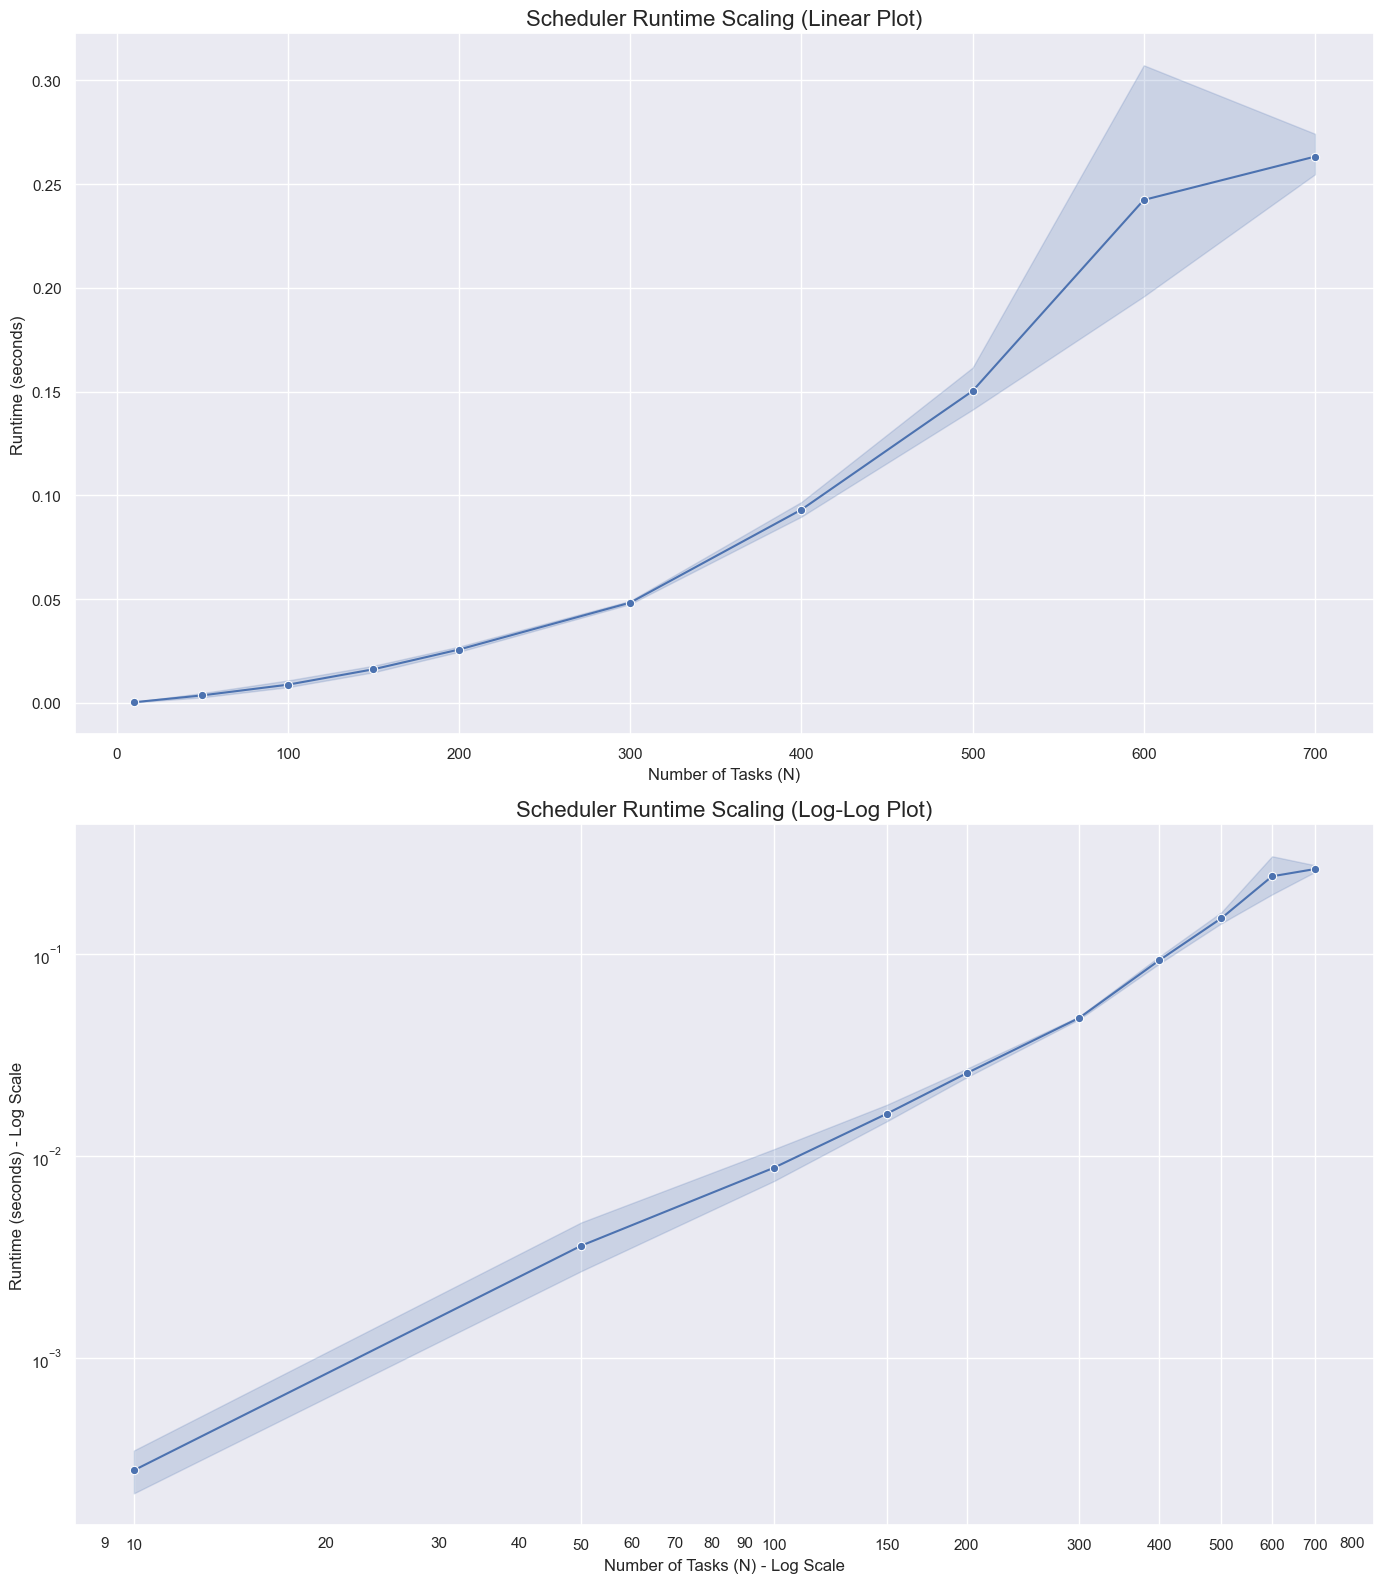

In [162]:
# Visualizations for the Running Time Complexity

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys
import os

def generate_test_tasks(n):
    """
    Generates a list of n tasks with randomized dependencies.
    
    To ensure the scheduler can run, dependencies are only
    ever on tasks with a smaller ID (creating a DAG).
    """
    tasks = []
    for i in range(n):
        # Each task has a 60% chance of having a dependency (Arbitrary decision)
        dependencies = []
        if i > 0 and random.random() < 0.60:
            # Depend on one random *previous* task
            dep_id = random.randint(0, i - 1)
            dependencies.append(dep_id)
            
        # We use simple, flexible tasks for this performance test
        tasks.append(
            Task(id=i, 
                 description=f"Task {i}", 
                 duration=random.randint(5, 60), 
                 dependencies=dependencies,
                 earliest_start_time=None,
                 latest_start_time=None
            )
        )
    return tasks

n_values = [10, 50, 100, 150, 200, 300, 400, 500, 600, 700]
n_trials = 10  # Small number of trials given large time complexity
results = []

print("Starting scheduler performance benchmark...")
print(f"N values: {n_values}")
print(f"Trials per N: {n_trials}\n")

benchmark_start_time = time.time()

for n in n_values:
    n_start_time = time.time()
    print(f"Processing N = {n:<4} (running {n_trials} trials)...", end="")
    
    for trial in range(n_trials):
        # Generate random set of tasks
        test_tasks = generate_test_tasks(n)
        
        # Create the scheduler
        scheduler = TaskScheduler(test_tasks)

        original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

        try:
            # Time the trial
            trial_start_time = time.perf_counter()
            
            scheduler.run_task_scheduler(starting_time=0)
            
            trial_end_time = time.perf_counter()
        
        finally:
            sys.stdout.close()
            sys.stdout = original_stdout

        # Record runtime
        runtime = trial_end_time - trial_start_time
        results.append({
            "N": n,
            "Trial": trial,
            "Runtime": runtime
        })
        
    n_end_time = time.time()
    print(f" done in {n_end_time - n_start_time:.2f} seconds.")

total_time = time.time() - benchmark_start_time
print(f"\nBenchmark complete in {total_time:.2f} seconds.")

# Data Processing and Plotting
df = pd.DataFrame(results)

# Set the plotting style
sns.set(style="darkgrid")
plt.figure(figsize=(14, 16))

# Plot 1: Linear Scale
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x="N", y="Runtime", marker='o')
plt.title("Scheduler Runtime Scaling (Linear Plot)", fontsize=16)
plt.xlabel("Number of Tasks (N)", fontsize=12)
plt.ylabel("Runtime (seconds)", fontsize=12)

# Plot 2: Log-log Scale
ax2 = plt.subplot(2, 1, 2)
sns.lineplot(data=df, x="N", y="Runtime", marker='o')
plt.xscale('log')
plt.yscale('log')
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_minor_formatter(ticker.ScalarFormatter())
plt.xticks(n_values) 

plt.title("Scheduler Runtime Scaling (Log-Log Plot)", fontsize=16)
plt.xlabel("Number of Tasks (N) - Log Scale", fontsize=12)
plt.ylabel("Runtime (seconds) - Log Scale", fontsize=12)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.show()